In [1]:
import numpy as np
import pandas as pd
import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

import sys
import operator

import fastparquet
import snappy

/Users/edasmalchi/anaconda3/envs/ox/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [2]:
def showall(df):
    #shows entire dataframe
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(df)

In [3]:
alldays_timestamped = pd.read_parquet('alldays_timestamped.parquet')
#alldays_timestamped = alldays_timestamped.droplevel('Vehicle_Location')

IndexError: list assignment index out of range

In [6]:
def plot_oneday(oneday_df, palette):
    #drop location from multiindex
    dropped = oneday_df.droplevel('Vehicle_Location')
    #remove locations besides spc 1-3, bike lane
    dropped = dropped[~dropped['Vehicle Location'].isin(['SB travel lane', 
                                                        'NB right turn pocket', 'Both/Middle of Space 1 & 2'])]
    #order locations
    dropped.sort_values(by=['Vehicle Location'], inplace=True)
    #create time column from index for x-axis, assign enforcement start time
    dropped['time'] = dropped.index
    enf_start = dropped.index[0].to_pydatetime().replace(hour=18, minute=0)
    enf_end = dropped.index[0].to_pydatetime().replace(hour=22, minute=0)
    #time range to display
    times = [min(dropped['time']), max(dropped['time'])]
    fig,ax = plt.subplots()
    #plot using Seaborn strip plot, set x-axis range, add line at enforcement start time, format x-axis...
    ax = sns.stripplot(x="time", y="Vehicle Location", hue='Violator', palette=palette, data=dropped, size = 2, jitter=False)
    ax.set_xlim(times)
    ax.axvline(enf_start, label='Loading Zone Start', c='r')
    ax.axvline(enf_end, label='Loading Zone End', c='g')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_title(oneday_df['Begin Date'][0])
    fig.autofmt_xdate()
    plt.show()

In [7]:
def plot_everything(allday_df):
    unique = allday_df['Violator'].unique()
    colors = ['green', 'tangerine', 'scarlet']
    palette = dict(zip(unique, sns.xkcd_palette(colors)))
    
    to_df = []
    for date in allday_df['Begin Date'].unique():
        oneday = allday_df[allday_df['Begin Date'] == date]
        #print(date)
        plot_oneday(oneday, palette)
    return

In [8]:
alldays_timestamped.sort_index(level='Timestamp', inplace=True)

In [17]:
oneday = alldays_timestamped.loc['2019-09-07 18:00:00':'2019-09-07 18:01:00']

In [10]:
twodays = alldays_timestamped.loc['2019-08-27 12:00:00':'2019-08-29 22:30:00']

In [55]:
def count_adv(df):
    #display(df)
    index = list(df['Violator'].unique()) + ['Both Violator'] + ['No Violator']
    series = pd.Series(data = 0, index = index, dtype=np.int64)
    #print('counting next df')
    for timestamp, newdf in df.groupby(level=0):
        #print('.')
        #display(newdf)
        one = pd.Series(data = 0, index = index, dtype=np.int64)
        one = one.add(newdf['Violator'].value_counts()).fillna(value=0)

        if 'Violator' in one.index and one['Violator'] == 2:
            one['Both Violator'] = 1
            one['Violator'] = 1
        if 'Violator' not in one.index:
            one['No Violator'] = 1
        
        series = series.add(one)
    if 'Likely Non-Violator' in series.index:
        series = series.drop(labels='Likely Non-Violator')
    return series

In [51]:
def rtn_groupby(df):
    #display(df)
    index = list(df['Violator'].unique()) + ['Both Violator'] + ['No Violator']
    series = pd.Series(data = 0, index = index, dtype=np.int64)
    #print('counting next df')
    return df.groupby(level=0)

In [53]:
def make_blocking_df(date_df_list):
    
    def make_blocking_df(dflist):

        blkdf = pd.DataFrame(dflist[1]).transpose()
        blkdf['Date'] = dflist[0]
        blkdf['Condition'] = 'Bike Lane Blocked'
        blkdf.set_index(['Date', 'Condition'], inplace=True)

        violdf = pd.DataFrame(dflist[2]).transpose()
        violdf['Date'] = dflist[0]
        violdf['Condition'] = 'Violator Present'
        violdf.set_index(['Date', 'Condition'], inplace=True)

        bothdf = blkdf.append(violdf)
        return bothdf

    if type(date_df_list[0]) == list:
        for dflist in date_df_list:
            try:
                outputdf = outputdf.append(make_blocking_df(dflist))
            except UnboundLocalError:
                outputdf = make_blocking_df(dflist)
        return outputdf
    else:
        return make_blocking_df(date_df_list)
    


In [13]:
def bigdf_at_times(littledf, bigdf):
    times = littledf.index
    bigdf = bigdf.loc[bigdf.index.isin(times)]
    bigdf.sort_index(inplace=True)
    return bigdf

In [31]:
def blocking_stats(bigdf, subset=None):
    bigdf = bigdf.droplevel('Vehicle_Location')
    df = bigdf.copy()
    
    if subset:
        df = subset
    #return
    #only look at blocking during loading zone time
    #df = df.droplevel('Vehicle_Location')
    df = df[df.index.hour >= 18]
    #generate df, stats for lane blocked-->violator present relationships
    
    blocked = df[df['Vehicle Location'] == 'SB bike lane']
    df_viol = df[df['Violator'] == 'Violator']
    
    viol_counts = count_adv(bigdf_at_times(df_viol, bigdf))
    blocked_counts = count_adv(bigdf_at_times(blocked, bigdf))
    try:
        date = df['Begin Date'][0]
        return [date, blocked_counts, viol_counts]
    except:
        print('blocking stats failed')
        return None

In [15]:
def daily_blocking_stats(allday_df):
    to_df = []
    for date in allday_df['Begin Date'].unique():
        oneday = allday_df[allday_df['Begin Date'] == date]
        day_block_stats = blocking_stats(oneday)
        to_df += [day_block_stats]
        #print(day_block_stats)
    to_df = list(filter(None, to_df))
    return to_df

In [ ]:
%prun -l 50 daily_blocking_stats(little)

In [65]:
little = alldays_timestamped.loc['2019-08-30 20:45:00':'2019-08-30 21:15:00']

In [ ]:
%prun -l 20 blocking_stats(little)

In [35]:
%prun -l 20 count_adv(little)

In [67]:
%time count_adv(little)

CPU times: user 5.76 s, sys: 59.4 ms, total: 5.82 s
Wall time: 6.06 s


Bike Lane Blocking     257.0
Both Violator            0.0
No Violator              0.0
Violator              1145.0
dtype: float64

In [52]:
def count_adv2(df):
    #display(df)
    index = list(df['Violator'].unique()) + ['Both Violator'] + ['No Violator']
    series = pd.Series(data = 0, index = index, dtype=np.int64)
    #print('counting next df')
    ##TODO find a way to do this with groupby.apply, probably way quicker
    for timestamp, newdf in df.groupby(level=0):
        #print('.')
        #display(newdf)
        one = pd.Series(data = 0, index = index, dtype=np.int64)
        one = one.add(newdf['Violator'].value_counts()).fillna(value=0)

        if 'Violator' in one.index and one['Violator'] == 2:
            one['Both Violator'] = 1
            one['Violator'] = 1
        if 'Violator' not in one.index:
            one['No Violator'] = 1
        
        series = series.add(one)
    if 'Likely Non-Violator' in series.index:
        series = series.drop(labels='Likely Non-Violator')
    return series

In [46]:
groupy = rtn_groupby(little)

In [47]:
groupy

how to find caller of builtins??

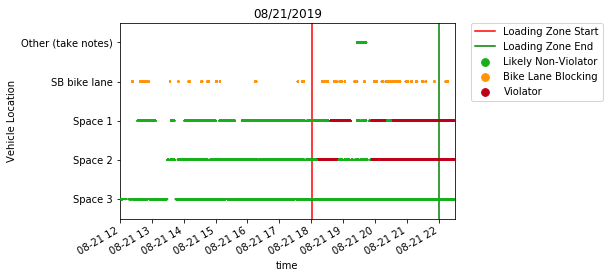

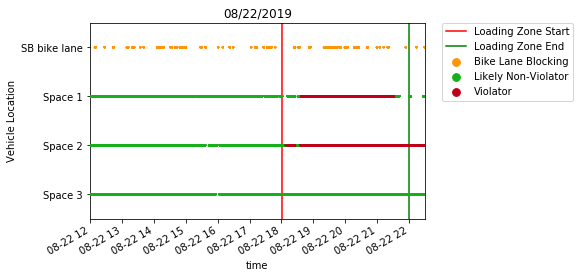

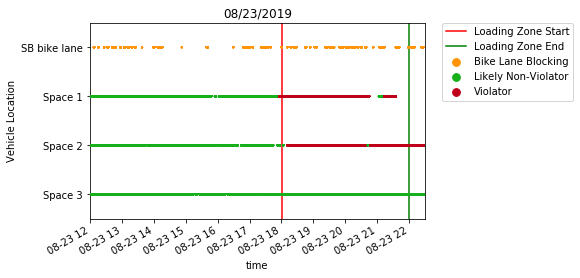

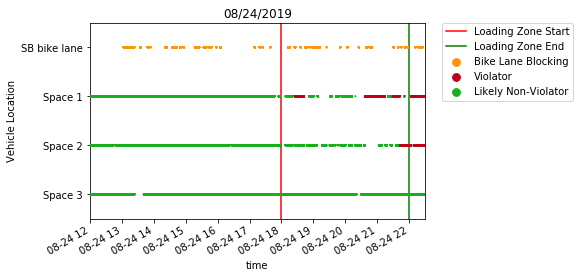

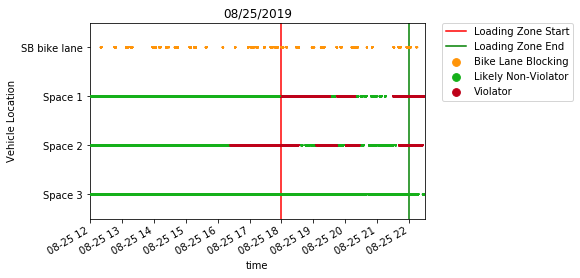

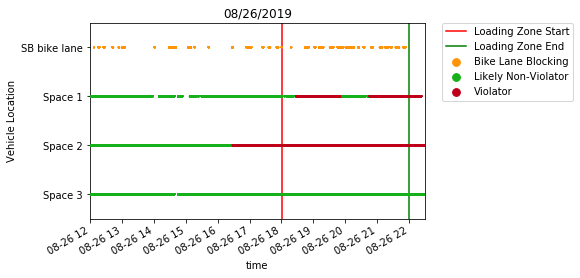

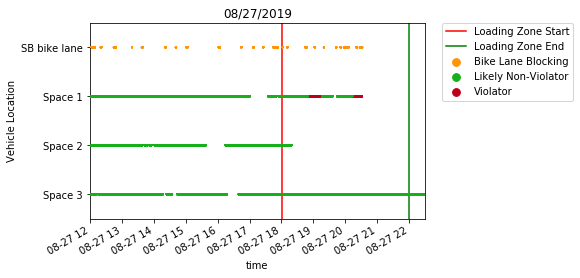

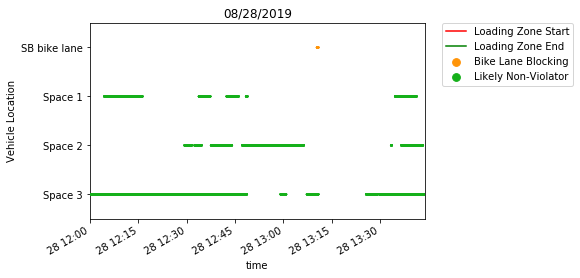

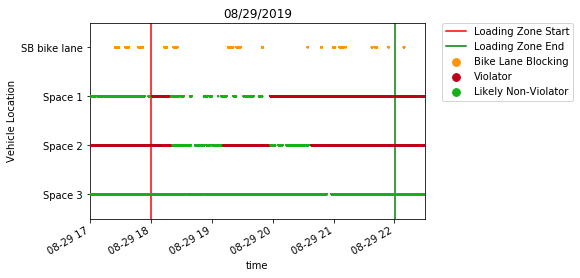

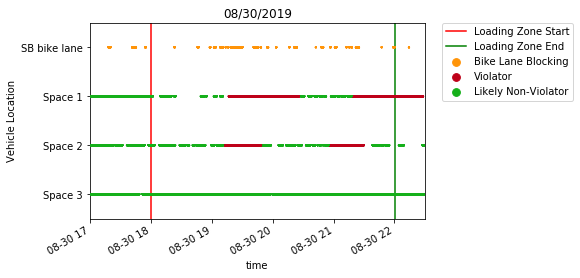

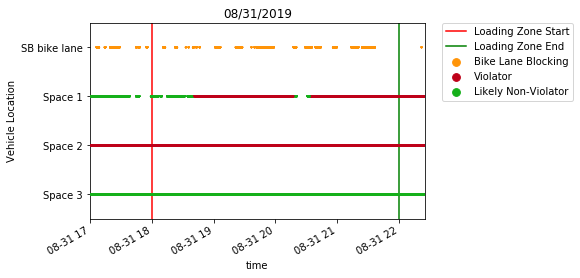

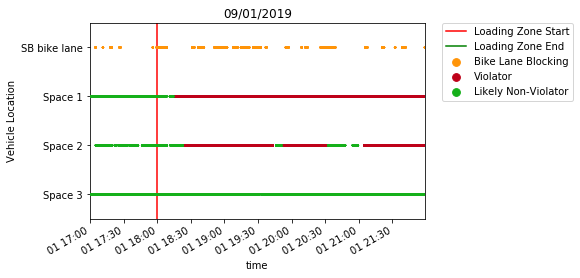

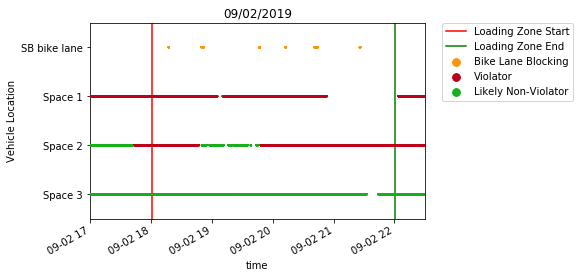

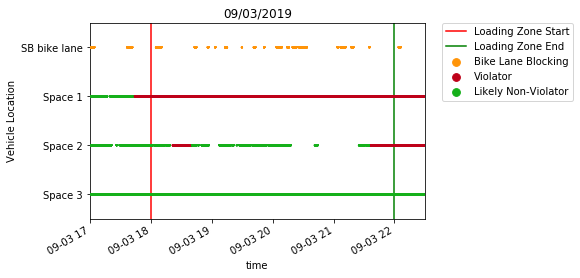

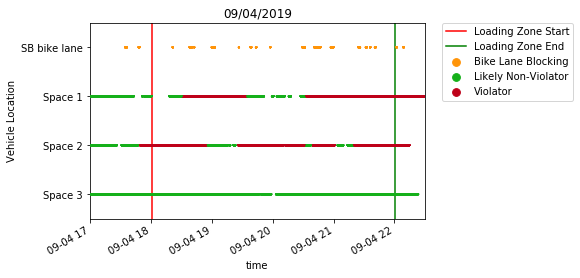

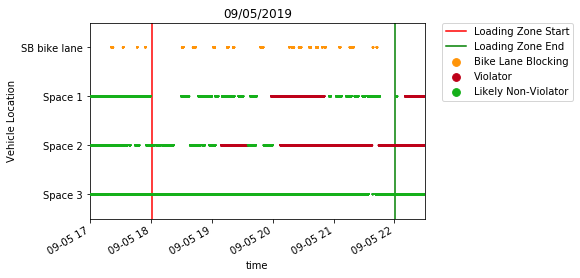

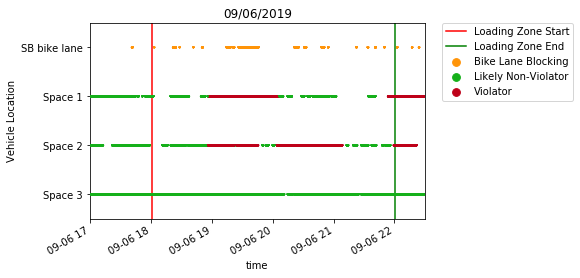

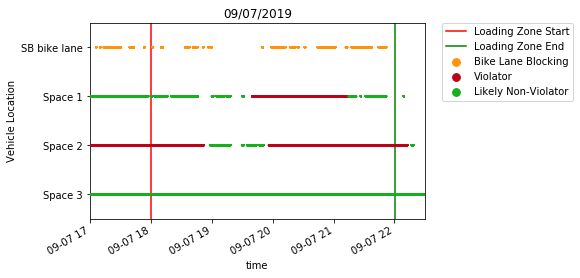

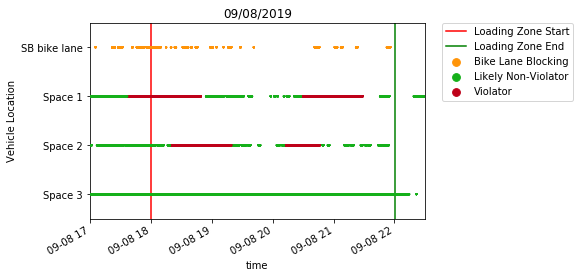

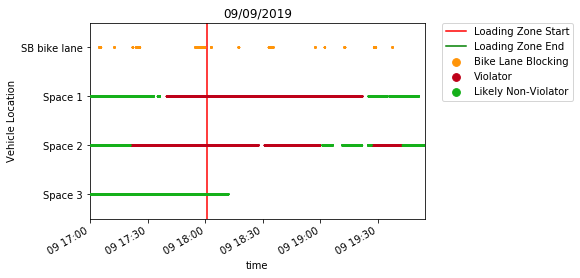

In [62]:
plot_everything(alldays_timestamped)

In [62]:
blocking_df = make_blocking_df(to_df)

In [69]:
blocking_df.to_parquet('blockingdf.parquet')

In [153]:
blocking_df = pd.read_parquet('blockingdf.parquet')

/Users/edasmalchi/anaconda3/envs/ox/lib/python3.7/site-packages/fastparquet/core.py:278: UserWarning: Non-categorical multi-index is likely brittle
  warnings.warn("Non-categorical multi-index is likely brittle")


In [154]:
blocking_df

Bike Lane Blocking  Both Violator  No Violator  \
Date       Condition                                                           
08/21/2019 Bike Lane Blocked              3267.0         2058.0          0.0   
           Violator Present               3216.0         9413.0          0.0   
08/22/2019 Bike Lane Blocked              3479.0         2677.0          0.0   
           Violator Present               3314.0        10650.0          0.0   
08/23/2019 Bike Lane Blocked              3594.0         2363.0          0.0   
           Violator Present               3594.0        10451.0          0.0   
08/24/2019 Bike Lane Blocked              1692.0           97.0          0.0   
           Violator Present                510.0         1254.0          0.0   
08/25/2019 Bike Lane Blocked              2580.0         1528.0          0.0   
           Violator Present               2510.0         7484.0          0.0   
08/26/2019 Bike Lane Blocked              3466.0         2268.0          0.0   
           Violator Present               3466.0        10855.0          0.0   
08/27/2019 Bike Lane Blocked               726.0            0.0          0.0   
           Violator Present                316.0            0.0          0.0   
08/29/2019 Bike Lane Blocked              1666.0          715.0          0.0   
           Violator Present               1453.0         7688.0          0.0   
08/30/2019 Bike Lane Blocked              2473.0         1063.0          0.0   
           Violator Present               2001.0         2570.0          0.0   
08/31/2019 Bike Lane Blocked              5061.0         3225.0          0.0   
           Violator Present               5061.0        12423.0          0.0   
09/01/2019 Bike Lane Blocked              4033.0         2956.0          0.0   
           Violator Present               3439.0        10346.0          0.0   
09/02/2019 Bike Lane Blocked               419.0          253.0          0.0   
           Violator Present                419.0         8298.0          0.0   
09/03/2019 Bike Lane Blocked              2652.0          123.0          0.0   
           Violator Present               2652.0         4303.0          0.0   
09/04/2019 Bike Lane Blocked              1488.0          979.0          0.0   
           Violator Present               1442.0         6570.0          0.0   
09/05/2019 Bike Lane Blocked              1727.0          513.0          0.0   
           Violator Present               1127.0         3782.0          0.0   
09/06/2019 Bike Lane Blocked              2881.0         1501.0          0.0   
           Violator Present               2411.0         4288.0          0.0   
09/07/2019 Bike Lane Blocked              5813.0         2019.0          0.0   
           Violator Present               5728.0         4683.0          0.0   
09/08/2019 Bike Lane Blocked              2447.0          694.0          0.0   
           Violator Present               2184.0         2841.0          0.0   
09/09/2019 Bike Lane Blocked               352.0          219.0          0.0   
           Violator Present                352.0         3413.0          0.0   

                              Violator  
Date       Condition                    
08/21/2019 Bike Lane Blocked    3055.0  
           Violator Present    13153.0  
08/22/2019 Bike Lane Blocked    2881.0  
           Violator Present    15246.0  
08/23/2019 Bike Lane Blocked    3427.0  
           Violator Present    16136.0  
08/24/2019 Bike Lane Blocked     509.0  
           Violator Present     7159.0  
08/25/2019 Bike Lane Blocked    2021.0  
           Violator Present    12360.0  
08/26/2019 Bike Lane Blocked    3281.0  
           Violator Present    16201.0  
08/27/2019 Bike Lane Blocked     316.0  
           Violator Present     2321.0  
08/29/2019 Bike Lane Blocked    1228.0  
           Violator Present    13176.0  
08/30/2019 Bike Lane Blocked    1644.0  
           Violator Present     9953.0  
08/31/201

In [67]:
violator = blocking_df.xs('Violator Present', level='Condition', drop_level=False)

## Moving Forwards
### short-term
* general speed-up (see Pandas advice, for loops, cython?, weird parallel thing, etc?)
    * Pandas 1.0 should help some too
* loading zone ends at 10pm
* show TNC/CNS activity on plot?
* Scatter/fit line of seconds blocked+seconds any violator?
* send visual/summary package to Juan for city meeting (Google Slides) (draft 1-2wk)

### longer-term
* rewrite to call blocking stats explicitly for each interval, support datetimeindex?
* count # of cars in bike lane, compare to 1 violator, 2 violator 
* --> model counterfactual, bike lane availability under perfect enforcement, (get sizing reccomendation, is 2 enough??, what about if there is no enforcement?? (bigger?) )
* OpenCV (w/ David?)
* interactive visualization tool, summary stats (late Feb?) (goal of project!)
* eventual paper on data/stats
* eventual tool description


In [141]:
def reset_viol_time(df, hour=22, opr='=='):
    
    ops = {'>': operator.gt,
           '<': operator.lt,
           '>=': operator.ge,
           '<=': operator.le,
           '==': operator.eq}
    
    df.sort_index(level='Timestamp', inplace=True)
    s = df.index.get_level_values(level='Timestamp')
    hr = ops[opr](s.hour, hour)
    filtered = df.loc[hr]
    filtered.loc[:, 'Violator'] = filtered.loc[:, 'Violator'].apply(lambda x: 'Likely Non-Violator' if x == 'Violator' else x)
    df = df.loc[~hr]
    df = df.append(filtered)
    return df

In [142]:
alldays_timestamped = reset_viol_time(alldays_timestamped)

In [143]:
alldays_timestamped = reset_viol_time(alldays_timestamped, hour=18, opr='<')

In [144]:
alldays_timestamped

Begin Date  Begin Time     End Time  \
Timestamp           Vehicle_Location                                        
2019-08-21 18:00:00 Space 3           08/21/2019  5:30:55 PM  10:30:00 PM   
2019-08-21 18:00:01 Space 3           08/21/2019  5:30:55 PM  10:30:00 PM   
2019-08-21 18:00:02 Space 3           08/21/2019  5:30:55 PM  10:30:00 PM   
2019-08-21 18:00:03 Space 3           08/21/2019  5:30:55 PM  10:30:00 PM   
2019-08-21 18:00:04 Space 3           08/21/2019  5:30:55 PM  10:30:00 PM   
...                                          ...         ...          ...   
2019-09-09 17:59:58 Space 3           09/09/2019  5:00:00 PM   6:12:11 PM   
2019-09-09 17:59:59 SB bike lane      09/09/2019  5:57:44 PM   6:00:02 PM   
                    Space 1           09/09/2019  5:39:57 PM   7:22:01 PM   
                    Space 2           09/09/2019  5:21:42 PM   6:27:52 PM   
                    Space 3           09/09/2019  5:00:00 PM   6:12:11 PM   

                                     Vehicle Location Vehicle Type  \
Timestamp           Vehicle_Location                                 
2019-08-21 18:00:00 Space 3                   Space 3          Car   
2019-08-21 18:00:01 Space 3                   Space 3          Car   
2019-08-21 18:00:02 Space 3                   Space 3          Car   
2019-08-21 18:00:03 Space 3                   Space 3          Car   
2019-08-21 18:00:04 Space 3                   Space 3          Car   
...                                               ...          ...   
2019-09-09 17:59:58 Space 3                   Space 3          Car   
2019-09-09 17:59:59 SB bike lane         SB bike lane          Car   
                    Space 1                   Space 1          Car   
                    Space 2                   Space 2          Car   
                    Space 3                   Space 3          Car   

                                     Vehicle Characteristics  \
Timestamp           Vehicle_Location                           
2019-08-21 18:00:00 Space 3                      Blinkers on   
2019-08-21 18:00:01 Space 3                      Blinkers on   
2019-08-21 18:00:02 Space 3                      Blinkers on   
2019-08-21 18:00:03 Space 3                      Blinkers on   
2019-08-21 18:00:04 Space 3                      Blinkers on   
...                                                      ...   
2019-09-09 17:59:58 Space 3                             None   
2019-09-09 17:59:59 SB bike lane                 Blinkers on   
                    Space 1                             None   
                    Space 2                             None   
                    Space 3                             None   

                                            Transaction Characteristics  \
Timestamp           Vehicle_Location                                      
2019-08-21 18:00:00 Space 3           No interaction with parking meter   
2019-08-21 18:00:01 Space 3           No interaction with parking meter   
2019-08-21 18:00:02 Space 3           No interaction with parking meter   
2019-08-21 18:00:03 Space 3           No interaction with parking meter   
2019-08-21 18:00:04 Space 3           No interaction with parking meter   
...                                                                 ...   
2019-09-09 17:59:58 Space 3                                        None   
2019-09-09 17:59:59 SB bike lane                                   None   
                    Space 1              Interaction with parking meter   
                    Space 2              Interaction with parking meter   
                    Space 3                                        None   

                                      Bikeway Users Displaced  LZ Space Avail  \
Timestamp           Vehicle_Location                                            
2019-08-21 18:00:00 Space 3                               NaN             0.0   
2019-08-21 18:00:01 Space 3                               NaN            